# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 3

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
model_dir = os.path.abspath("../mass_user/models")
maps_dir = os.path.abspath("../mass_user/maps")
data_dir = os.path.abspath("../mass_user/data")

In [4]:
# model_dir = os.path.abspath(".../MASSliver/models")
# maps_dir = os.path.abspath(".../MASSliver/models/maps")
# data_dir = os.path.abspath(".../MASSliver/data/interim")

In [5]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [6]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07fc457b92810
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [7]:
trial = Model('Smaller Glycogenolysis') 
trial

Name,Smaller Glycogenolysis
Memory address,0x07fc457c25d90
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


In [8]:
# core_model.reactions.EX_glc__D_c.remove_from_model()

In [9]:
## adding reactions from Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [10]:
## adding reactions from glycogenloysis 
gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))

In [11]:
r_list=[
    'HEX1',
    'G6PPer',
    'G6Pter',
    'GLCter',
    'PGI', 
#     'EX_pyr_e',
#     'EX_lac__L_e'  
]
for rid in r_list:
    reaction = core_model.reactions.get_by_id(rid)
    trial.add_reactions([reaction])  
r_list_2=[
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'EX_glc__D_e',
    'GLCt1',
    'Ht'
]
for rid in r_list_2:
    reaction = R3D.reactions.get_by_id(rid)
    trial.add_reactions([reaction])

In [12]:
 trial.add_reactions([R3D.reactions.get_by_id('Ht')])

Ignoring reaction 'Ht' since it already exists.


In [13]:
## change after double checking this, maybe not needed to be added to core?

f=gly.reactions.SK_f6p_c
g= gly.reactions.SK_g6p_c

new_r_list=[
    f,
    g    
]


In [14]:
for x in new_r_list:
    c= x
    trial.add_reaction(c)

In [15]:
# create exchange reaction
atp=R3D.metabolites.get_by_id('atp_c')
adp=R3D.metabolites.get_by_id('adp_c')
h2o=R3D.metabolites.get_by_id('h2o_e')
pie=R3D.metabolites.get_by_id('pi_e')
he=R3D.metabolites.get_by_id('h_e')

In [16]:
# create exchange reaction
trial.add_boundary(atp, type="sink")
trial.add_boundary(adp, type="sink")
trial.add_boundary(h2o, type="exchange")
trial.add_boundary(pie, type="exchange")
trial.add_boundary(he, type="exchange")

Reaction identifier,EX_h_e
Name,H+ exchange
Memory address,0x07fc456977710
Stoichiometry,h_e <=> H+ <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [17]:
trial.reactions.SK_f6p_c

Reaction identifier,SK_f6p_c
Name,D-Fructose 6-phosphate sink
Memory address,0x07fc456a07e90
Stoichiometry,f6p_c <=> D-Fructose 6-phosphate <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


## View Escher map

In [18]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [19]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [20]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"2.7-srp-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1)
flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
G6PPer,0.001682
HEX1,0.000000
GLCt1,-0.001682
PGI,-0.002919
EX_glc__D_e,0.085498
SK_f6p_c,0.002919


In [21]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
# irreversible_enzyme_pairs = ["PFK", "FBP"]
irreversible_enzyme_pairs2 = ["HEX1", "G6PPer"]


In [22]:
for rid, flux in flux_df.itertuples():
    reaction = trial.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
#     if (rid == "EX_lac__L_e"): #uptake
#         pass
# #         reaction = trial.reactions.get_by_id(rid)
# #         reaction.bounds = (0,1000) 
    if (rid == "EX_glc__L_e"): #secretion
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (-0.085498214,0.085498214) 
#     elif (rid == "EX_pyr_e"): #uptake
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (0, 1000) 
#     elif (rid == "SK_f6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "SK_g6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "EX_glygn2_c"): #uptake
#         reaction = core_model.reactions.get_by_id(rid)
#         reaction.bounds = (-1, 1000) 
#     for irreversible_enzyme_pair in irreversible_enzyme_pairs:
#         if rid in irreversible_enzyme_pair:
#             flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
#             if flux1 == 0:
#                 flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
#             if flux2 == 0:
#                 flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
    for irreversible_enzyme_pair in irreversible_enzyme_pairs2:
        if rid in irreversible_enzyme_pair:
            flux3, flux4 = flux_df.loc[irreversible_enzyme_pairs2, "Flux (mmol/gDW*hr)"].values
            if flux3 == 0:
                flux += reverse_flux_percent * flux4 # mmol*gDW^-1*hr^-1
            if flux4 == 0:
                flux += reverse_flux_percent * flux3 # mmol*gDW^-1*hr^-1
                
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

G6PPer 0.0018502083831
HEX1 0.00016820076210000002
GLCt1 -0.001682007621
PGI -0.002918552036
EX_glc__D_e 0.0854982138575
SK_f6p_c 0.002918552


In [23]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
trial.objective = objective[0]
trial.objective_direction = "min"

flux_solution = trial.optimize()

In [24]:
# ab=pd.DataFrame(flux_solution.fluxes)
# ab.to_excel("output.xlsx")
flux_solution.fluxes

HEX1           0.000168
G6PPer         0.001850
G6Pter         0.001850
GLCter        -0.001850
PGI           -0.001682
H2Oter         0.001850
PIter          0.001850
H2Ot           0.001850
PIt            0.001850
EX_glc__D_e    0.001682
GLCt1         -0.001682
Ht            -0.000168
SK_f6p_c      -0.001682
SK_g6p_c       0.000000
SK_atp_c      -0.000168
SK_adp_c       0.000168
EX_h2o_e      -0.001850
EX_pi_e        0.001850
EX_h_e         0.000168
Name: fluxes, dtype: float64

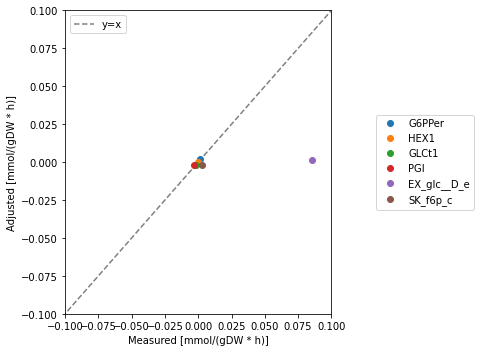

In [25]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.1,0.1), ylim=(-0.1, 0.1),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [26]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x07fc451db2e50
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [27]:
#add reactions one at a time
##G6PPer, HEX1, GLCt1, PGI

# EX_glc__D_e    0.001682

# SK_f6p_c      -0.001682
# SK_g6p_c       0.000000
# SK_atp_c      -0.000168
# SK_adp_c       0.000168
# EX_h2o_e      -0.001850
# EX_pi_e        0.001850
# EX_h_e         0.000168


reaction_list=[]
reaction_list = ['HEX1',
                 'GLCt1',
                 'G6Pter',
                 'G6PPer',
                 'GLCter',
#                  'EX_glc__D_e',
                'PGI',
                 'H2Oter',
                'PIter',
                'H2Ot',
                'PIt',
                'Ht'
#                 #'FBP',
#                 'PFK',
#                 'FBA',
#                 'TPI',
#                 'GAPD',
#                 'PGK',
#                 'PGM',
#                 'ENO',
#                 #'PEPtm',
#                 #'PEPCKm',
#                 #'LDH_L',
#                 'PYK'
#                 #'PCm',
#                 #'PYRt2m'
                ]


In [28]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = trial.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

##  Set Fluxes

In [29]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.00021506233542487052
v_GLCt1: -0.002150623354248705
v_G6Pter: 0.002365685689673576
v_G6PPer: 0.002365685689673576
v_GLCter: -0.002365685689673576
v_PGI: -0.002150623354248705
v_H2Oter: 0.002365685689673576
v_PIter: 0.002365685689673576
v_H2Ot: 0.002365685689673576
v_PIt: 0.002365685689673576
v_Ht: -0.00021506233542487052


## Set Keqs

In [30]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,3000.000000
G6PPer,41.300000
PGI,0.300000
G6Pter,2.761096
GLCter,1.000000


In [31]:
Keq_list =[]
#setting exchange constants as 1

transport= [
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'Ht'   
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.Keq=1
    
    
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
            

        

Keq_GLCt1: 1.0
Keq_HEX1: 3000.0
Keq_G6PPer: 41.3
Keq_PGI: 0.3
Keq_G6Pter: 2.761096464
Keq_GLCter: 1.0


## Obtain Concentrations

In [32]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744
glc__D_r,D-Glucose,0.010483
f6p_c,D-Fructose-6-phosphate,0.000127
glc__D_e,D-Glucose,0.000000


In [33]:
#Set Concentrations

metabolite_list = [
                    # HEX1    
                    'glc__D_c',
                    'g6p_c',
                    'adp_c',
                    'atp_c',
                    #'pi_c',
                    'h_c',

                    # GLCt1
                    'glc__D_e',

                    # #G6Pter
                    'g6p_r',

                    # #G6PPer , #GLCter
                    'h2o_r',
                    'glc__D_r',
                    'pi_r',
#                     'PGI',
'f6p_c', 
#                     'H2Oter',
'h2o_c',

#                     'PIter',
'pi_r',
'pi_c',

#                     'H2Ot',
'h2o_e',
#                     'PIt',
'pi_e',

#                     'Ht'
'h_e'  ]

In [34]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

## Set H2O/H Constants

In [35]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c",'h_e',
    'h2o_r','h2o_e',
    "glc__D_e"    
       #'h_i'
       #'h_m' 
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [36]:
for metabolite in [
    #'h_i',
    #'h_m',
"h_c", 'h_e',
"h2o_c",'h2o_r','h2o_e' 
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
# glycogenolysis.metabolites.glc__D_e.ic= 0 #setting extracellular glucose as 0 because no lactate rn


    
#plasma phsophate concentration to be equal to intracellular plasma concentration
glycogenolysis.metabolites.pi_e.ic=0.0097441228

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
glc__D_e: 0.0
g6p_r: 0.000386553505
glc__D_r: 0.01048280703
h2o_r: 1
pi_r: 0.0097441228
f6p_c: 0.00012713765
h2o_c: 1
pi_c: 0.0064
h2o_e: 1
pi_e: 0.0097441228
h_e: 1


In [37]:
glycogenolysis.reactions.G6Pter.stoichiometry

[1.0, -1.0]

In [38]:
glycogenolysis.reactions.G6Pter

Reaction identifier,G6Pter
Name,Glucose 6 phosphate endoplasmic reticular transport via diffusion
Memory address,0x07fc451e11b50
Subsystem,"Transport, endoplasmic reticular"
Kinetic Reversibility,True
Stoichiometry,g6p_c <=> g6p_r D-Glucose 6-phosphate <=> D-Glucose 6-phosphate
GPR,2542_AT1
Bounds,"(-1000.0, 1000.0)"


In [39]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c",'h_e',
    'h2o_r','h2o_e',"h2o_c",
        "pi_e",
        "glc__D_e"
    ], excluded_reactions=["Ht", "H2Ot", "H2Oter",
                            'PIter',
                            'PIt',
                           'G6Pter',
                           'GLCter',
                           'GLCt1'
                          ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000140,0.0
glc__D_c,0.010483,0.0
g6p_r,0.000387,0.0
...,...,...
f6p_c,0.000127,0.0
pi_c,0.006400,0.0
Keq_HEX1,3000.000000,0.0
Keq_G6PPer,41.300000,0.0


In [40]:
conc_solution.concentrations

adp_c       0.001995
atp_c       0.004727
g6p_c       0.000140
glc__D_c    0.010483
g6p_r       0.000387
glc__D_r    0.010483
pi_r        0.009744
f6p_c       0.000127
pi_c        0.006400
Name: concentrations, dtype: float64

In [41]:
for c in conc_solver.constraints:
    print(c)

HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= -1
G6PPer: -1.0*Keq_G6PPer - 1.0*g6p_r + 1.0*glc__D_r + 1.0*pi_r <= -1
PGI: 1 <= -1.0*Keq_PGI + 1.0*f6p_c - 1.0*g6p_c


mass/visualization/visualization_util.py:1270 UserWarning: Ignoring {'glc__D_e'}, only in one set of given values


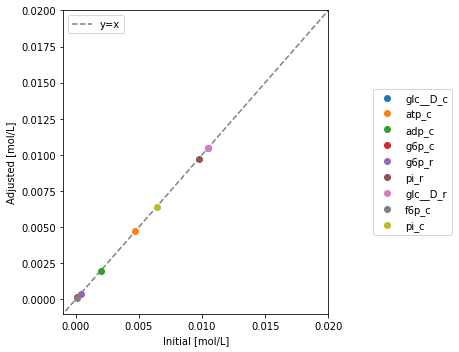

In [42]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.001,0.02), ylim=(-0.001,0.02),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [43]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,g6p_r,glc__D_r,pi_r,f6p_c,pi_c
0,0.000206,0.004098,0.000029,0.009070,0.002652,0.016313,0.021478,0.000025,0.000783
1,0.004017,0.001011,0.000570,0.003996,0.001429,0.002887,0.094232,0.000497,0.001275
2,0.004195,0.000576,0.000267,0.004708,0.002111,0.084347,0.093029,0.000241,0.012421


## Set concentrations and balance models with pseudoreactions

In [44]:
glycogenolysis.boundary_conditions['glc__D_b']=0.010482807

In [45]:
glycogenolysis.steady_state_fluxes 

{<MassReaction HEX1 at 0x7fc451e25050>: 0.00021506233542487052,
 <MassReaction GLCt1 at 0x7fc451e25e50>: -0.002150623354248705,
 <MassReaction G6Pter at 0x7fc451e11b50>: 0.002365685689673576,
 <MassReaction G6PPer at 0x7fc451e11810>: 0.002365685689673576,
 <MassReaction GLCter at 0x7fc451e11410>: -0.002365685689673576,
 <MassReaction PGI at 0x7fc456cbbf90>: -0.002150623354248705,
 <MassReaction H2Oter at 0x7fc451e25d90>: 0.002365685689673576,
 <MassReaction PIter at 0x7fc451c71a10>: 0.002365685689673576,
 <MassReaction H2Ot at 0x7fc457c174d0>: 0.002365685689673576,
 <MassReaction PIt at 0x7fc451ceaa90>: 0.002365685689673576,
 <MassReaction Ht at 0x7fc451db2650>: -0.00021506233542487052}

In [46]:
# glycogenolysis.steady_state_fluxes.values
glycogenolysis.update_S(array_type="DataFrame")

,HEX1,GLCt1,G6Pter,G6PPer,GLCter,PGI,H2Oter,PIter,H2Ot,PIt,Ht
adp_c,1,0,0,0,0,0,0,0,0,0,0
atp_c,-1,0,0,0,0,0,0,0,0,0,0
g6p_c,1,0,-1,0,0,-1,0,0,0,0,0
glc__D_c,-1,1,0,0,-1,0,0,0,0,0,0
h_c,1,0,0,0,0,0,0,0,0,0,1
glc__D_e,0,-1,0,0,0,0,0,0,0,0,0
g6p_r,0,0,1,-1,0,0,0,0,0,0,0
glc__D_r,0,0,0,1,1,0,0,0,0,0,0
h2o_r,0,0,0,-1,0,0,1,0,0,0,0
pi_r,0,0,0,1,0,0,0,-1,0,0,0


In [47]:
glycogenolysis.metabolites.adp_c.compartment

'c'

In [48]:
glycogenolysis.reactions.G6PPer.Keq

41.29999999999999

In [49]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0 and new_model.metabolites.get_by_id(mid).compartment!= "e": # to remove SK_glc__D_e
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            percs = new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=False)
            print(percs)
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(len(models_for_ensemble)))
# print(models_for_ensemble)

Negative PERCs for Glycogenolysis_C0
{'kf_HEX1': 5.786081277960998, 'kf_GLCt1': 0.23711406367234114, 'kf_G6Pter': -2.5409795874455283, 'kf_G6PPer': 0.8949952058737493, 'kf_GLCter': 0.3266253682553801, 'kf_PGI': 40.41718432668467, 'kf_H2Oter': 100000.0, 'kf_PIter': 0.11431007281805344, 'kf_H2Ot': 100000.0, 'kf_PIt': -0.2639931058214412, 'kf_Ht': 100000.0}
Negative PERCs for Glycogenolysis_C0
{'kf_HEX1': 5.786081277960998, 'kf_GLCt1': 0.23711406367234114, 'kf_G6Pter': -2.5409795874455283, 'kf_G6PPer': 0.8949952058737493, 'kf_GLCter': 0.3266253682553801, 'kf_PGI': 40.41718432668467, 'kf_H2Oter': 100000.0, 'kf_PIter': 0.11431007281805344, 'kf_H2Ot': 100000.0, 'kf_PIt': -0.2639931058214412, 'kf_Ht': 100000.0}
Negative PERCs for Glycogenolysis_C0
{'kf_HEX1': 5.786081277960998, 'kf_GLCt1': 0.23711406367234114, 'kf_G6Pter': -2.5409795874455283, 'kf_G6PPer': 0.8949952058737493, 'kf_GLCter': 0.3266253682553801, 'kf_PGI': 40.41718432668467, 'kf_H2Oter': 100000.0, 'kf_PIter': 0.11431007281805344, 

ZeroDivisionError: float division by zero

#### Ensure model is in steady state and export

In [ ]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

In [ ]:

# glycogenolysis.reactions.EX_glc__D_e.kf= 1000
for reaction in glycogenolysis.reactions:
    print(reaction.id, reaction.kf)

In [ ]:
glycogenolysis.reactions.PIter

In [ ]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1


# glycolysis.metabolites.h_c.charge=1
# glycolysis.metabolites.h_m.charge=1
# glycolysis.metabolites.h_i.charge=1
glycogenolysis.metabolites.pi_c.charge=-2
# glycolysis.metabolites.pi_m.charge=-2
glycogenolysis.metabolites.pi_r.charge=-2


In [ ]:
# glycogenolysis.calculate_PERCs(update_reactions=True)

# print("Forward Rate Constants\n----------------------")
# for reaction in glycogenolysis.reactions:
#     print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

In [ ]:
models_for_ensemble = []
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


In [ ]:
for x in range(len(glycogenolysis.genes)):
    a= glycogenolysis.genes[x]
    glycogenolysis.genes.remove(a)



In [ ]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Flux [mol/L*hr]",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

